# Lab5 11357045 伍修儀
# 使用Transformer進行天氣預測

這個notebook展示如何使用PyTorch實現的Transformer模型來預測天氣數據。我們將使用Jena氣候數據集,預測未來12小時的溫度變化。

In [78]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf  # 僅用於下載數據
from tqdm.notebook import tqdm # 用於Pytorch 訓練進度條

In [79]:
# 在開始訓練前添加GPU信息顯示
print(f"是否可用 CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"當前GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU記憶體使用: {torch.cuda.memory_allocated(0)/1024**2:.1f} MB")

# 設置設備和模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")

是否可用 CUDA: True
當前GPU: NVIDIA GeForce RTX 3080
GPU記憶體使用: 28.6 MB
使用設備: cuda


In [80]:
import torch
print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA是否可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA版本: {torch.version.cuda}")
    print(f"當前GPU: {torch.cuda.get_device_name(0)}")

PyTorch版本: 2.2.2+cu121
CUDA是否可用: True
CUDA版本: 12.1
當前GPU: NVIDIA GeForce RTX 3080


## 數據準備
首先下載並加載Jena氣候數據集

In [81]:
# 下載數據
zip_path = tf.keras.utils.get_file(
    origin='https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
filename = os.path.splitext(zip_path)[0]

# 讀取數據
df = pd.read_csv(filename)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


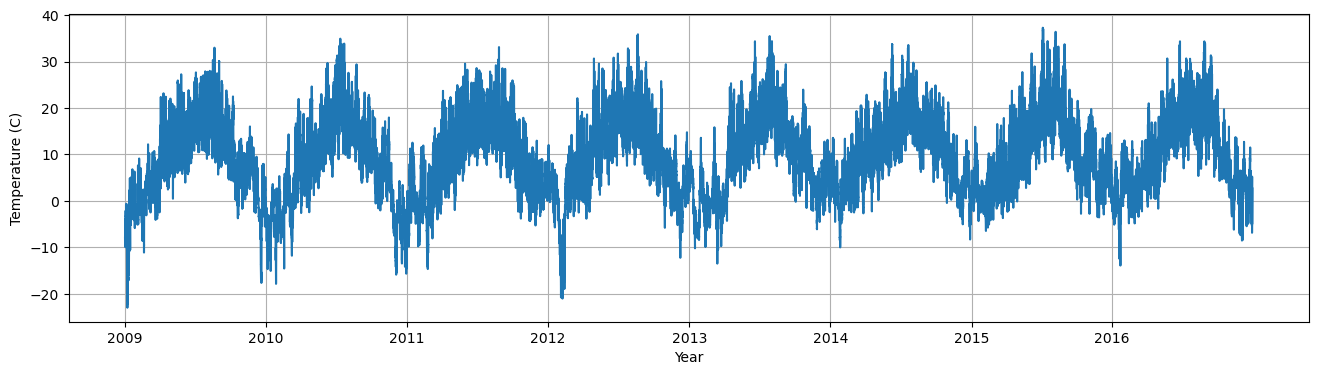

In [82]:
year_idx  = [np.argwhere(df['Date Time'] == '01.01.{} 00:10:00'.format(year)).ravel()[0] for year in range(2009,2017)]
year_label= [str(year) for year in range(2009,2017)]
temperature_df       = df['T (degC)']
temperature_df.index = df['Date Time']
ax = temperature_df.plot(xticks=year_idx,rot=0,figsize=(16,4))
ax.set_xticklabels(year_label)
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('Year')
ax.grid(True)

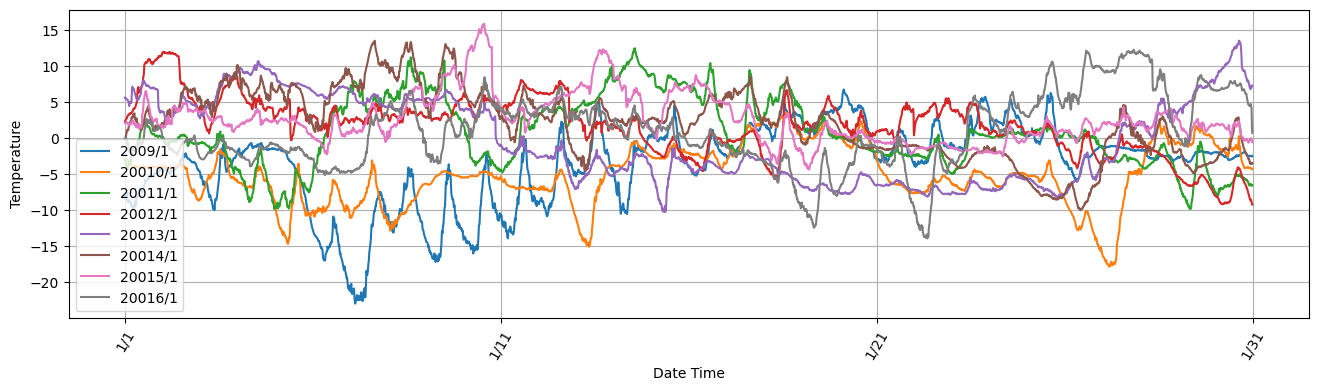

In [83]:
for y,year_start in enumerate(year_idx):
    ax = temperature_df[year_start:year_start+4320].plot(rot=60,figsize=(16,4),label='200{}/1'.format(y+9))
    ax.grid(True)
    ax.set_ylabel('Temperature')
    ax.set_xlabel('Date Time')
ax.set_xticks([6*24*10*i for i in range(0,4)])
ax.set_xticklabels(['1/{}'.format(i*10+1) for i in range(0,4)])    
ax.legend();

## 數據預處理
定義數據預處理函數並創建訓練序列

In [84]:
def create_sequences(data, train_timesteps=120, pred_timesteps=72, step=1):
    sequences = []
    targets = []
    
    for i in range(0, len(data) - train_timesteps - pred_timesteps + 1, step):
        seq = data[i:i + train_timesteps]
        target = data[i + train_timesteps:i + train_timesteps + pred_timesteps, 1]  # 只取溫度值
        sequences.append(seq)
        targets.append(target)
        
    return np.array(sequences), np.array(targets)

# 選擇需要的特徵
features = ['T (degC)', 'p (mbar)', 'rh (%)']
data = df[features].values

# 數據標準化
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# 創建訓練集和驗證集
train_split = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_split]
valid_data = scaled_data[train_split:]

# 創建序列
train_timesteps = 120  # 12小時
pred_timesteps = 72   # 預測未來12小時
step = 6

X_train, y_train = create_sequences(train_data, train_timesteps, pred_timesteps, step)
X_valid, y_valid = create_sequences(valid_data, train_timesteps, pred_timesteps, step)

print(f"訓練數據形狀: {X_train.shape}, {y_train.shape}")
print(f"驗證數據形狀: {X_valid.shape}, {y_valid.shape}")

訓練數據形狀: (56029, 120, 3), (56029, 72)
驗證數據形狀: (13984, 120, 3), (13984, 72)


## 定義模型架構
實現Dataset類和Transformer模型

In [85]:
class WeatherDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

    
class WeatherTransformer(nn.Module):
    def __init__(self, input_dim=3, d_model=128, nhead=8, num_layers=4, output_dim=72, max_seq_length=120, pos_encoding_type=1):
        super().__init__()
        
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoding_type = pos_encoding_type
        
        # 可學習的位置編碼
        self.learnable_pe = nn.Parameter(torch.zeros(1, max_seq_length, d_model))
        nn.init.xavier_uniform_(self.learnable_pe)
        
        # 正弦余弦位置編碼
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('sincos_pe', pe.unsqueeze(0))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model*4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        
        self.output_proj = nn.Linear(d_model, output_dim)
        
    def forward(self, x):
        x = self.input_proj(x)
        
        # 根據pos_encoding_type選擇位置編碼方式
        if self.pos_encoding_type == 0:
            x = x + self.learnable_pe[:, :x.size(1)]
        else:
            x = x + self.sincos_pe[:, :x.size(1)]
            
        output = self.transformer_encoder(x)
        output = output[:,-1,:]  # 使用最後一個時間步的輸出
        output = self.output_proj(output)
        return output

## 訓練和驗證函數

In [86]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    # 添加進度條
    pbar = tqdm(train_loader, desc='Training')
    for batch_x, batch_y in pbar:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # 更新進度條顯示當前loss
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(train_loader)

def validate(model, valid_loader, criterion, device):
    model.eval()
    total_loss = 0
    # 添加進度條
    pbar = tqdm(valid_loader, desc='Validating')
    with torch.no_grad():
        for batch_x, batch_y in pbar:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            total_loss += loss.item()
            # 更新進度條顯示當前loss
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(valid_loader)




## 訓練模型

In [87]:
# 設置參數
BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 創建數據加載器
train_dataset = WeatherDataset(X_train, y_train)
valid_dataset = WeatherDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

# 訓練前清理GPU記憶體
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# 初始化模型
model = WeatherTransformer().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 訓練循環
train_losses = []
valid_losses = []


try:
    for epoch in tqdm(range(EPOCHS), desc='Epochs'):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        valid_loss = validate(model, valid_loader, criterion, device)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        print(f'\nEpoch {epoch+1}/{EPOCHS}:')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}')
except KeyboardInterrupt:
    print('訓練被手動中斷')
finally:
    # 清理GPU記憶體
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 1/50:
Train Loss: 0.2903
Valid Loss: 0.0798


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 2/50:
Train Loss: 0.0924
Valid Loss: 0.0507


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 3/50:
Train Loss: 0.0734
Valid Loss: 0.0450


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 4/50:
Train Loss: 0.0659
Valid Loss: 0.0447


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 5/50:
Train Loss: 0.0612
Valid Loss: 0.0417


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 6/50:
Train Loss: 0.0581
Valid Loss: 0.0399


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 7/50:
Train Loss: 0.0561
Valid Loss: 0.0395


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 8/50:
Train Loss: 0.0542
Valid Loss: 0.0407


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 9/50:
Train Loss: 0.0531
Valid Loss: 0.0387


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 10/50:
Train Loss: 0.0516
Valid Loss: 0.0398


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 11/50:
Train Loss: 0.0506
Valid Loss: 0.0390


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 12/50:
Train Loss: 0.0499
Valid Loss: 0.0382


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 13/50:
Train Loss: 0.0492
Valid Loss: 0.0386


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 14/50:
Train Loss: 0.0484
Valid Loss: 0.0385


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 15/50:
Train Loss: 0.0478
Valid Loss: 0.0379


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 16/50:
Train Loss: 0.0470
Valid Loss: 0.0383


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 17/50:
Train Loss: 0.0466
Valid Loss: 0.0383


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 18/50:
Train Loss: 0.0460
Valid Loss: 0.0381


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 19/50:
Train Loss: 0.0454
Valid Loss: 0.0379


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 20/50:
Train Loss: 0.0448
Valid Loss: 0.0377


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 21/50:
Train Loss: 0.0448
Valid Loss: 0.0382


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 22/50:
Train Loss: 0.0443
Valid Loss: 0.0377


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 23/50:
Train Loss: 0.0440
Valid Loss: 0.0371


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 24/50:
Train Loss: 0.0434
Valid Loss: 0.0381


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 25/50:
Train Loss: 0.0436
Valid Loss: 0.0375


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 26/50:
Train Loss: 0.0428
Valid Loss: 0.0379


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 27/50:
Train Loss: 0.0432
Valid Loss: 0.0376


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 28/50:
Train Loss: 0.0420
Valid Loss: 0.0372


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 29/50:
Train Loss: 0.0421
Valid Loss: 0.0376


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 30/50:
Train Loss: 0.0417
Valid Loss: 0.0392


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 31/50:
Train Loss: 0.0412
Valid Loss: 0.0372


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 32/50:
Train Loss: 0.0409
Valid Loss: 0.0368


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 33/50:
Train Loss: 0.0405
Valid Loss: 0.0370


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 34/50:
Train Loss: 0.0408
Valid Loss: 0.0385


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 35/50:
Train Loss: 0.0403
Valid Loss: 0.0371


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 36/50:
Train Loss: 0.0400
Valid Loss: 0.0376


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 37/50:
Train Loss: 0.0396
Valid Loss: 0.0375


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 38/50:
Train Loss: 0.0396
Valid Loss: 0.0387


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 39/50:
Train Loss: 0.0393
Valid Loss: 0.0397


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 40/50:
Train Loss: 0.0388
Valid Loss: 0.0369


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 41/50:
Train Loss: 0.0384
Valid Loss: 0.0373


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 42/50:
Train Loss: 0.0385
Valid Loss: 0.0367


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 43/50:
Train Loss: 0.0382
Valid Loss: 0.0367


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 44/50:
Train Loss: 0.0377
Valid Loss: 0.0367


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 45/50:
Train Loss: 0.0376
Valid Loss: 0.0379


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 46/50:
Train Loss: 0.0373
Valid Loss: 0.0374


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 47/50:
Train Loss: 0.0372
Valid Loss: 0.0390


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 48/50:
Train Loss: 0.0370
Valid Loss: 0.0382


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 49/50:
Train Loss: 0.0368
Valid Loss: 0.0378


Training:   0%|          | 0/219 [00:00<?, ?it/s]

Validating:   0%|          | 0/55 [00:00<?, ?it/s]


Epoch 50/50:
Train Loss: 0.0361
Valid Loss: 0.0383


## 視覺化結果

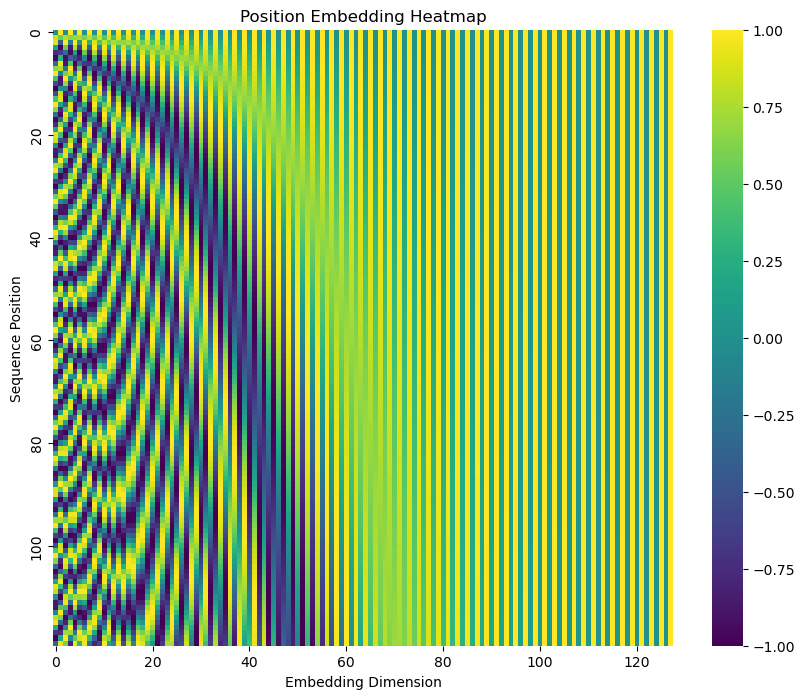

In [88]:
import seaborn as sns

def plot_position_embedding(model):
    if model.pos_encoding_type == 0:
        pos_embedding = model.learnable_pe.detach().cpu().numpy()[0]
    else:
        pos_embedding = model.sincos_pe.detach().cpu().numpy()[0]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(pos_embedding, 
                cmap='viridis',
                xticklabels=20,  
                yticklabels=20)
    plt.title('Position Embedding Heatmap')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Sequence Position')
    plt.show()

plot_position_embedding(model)

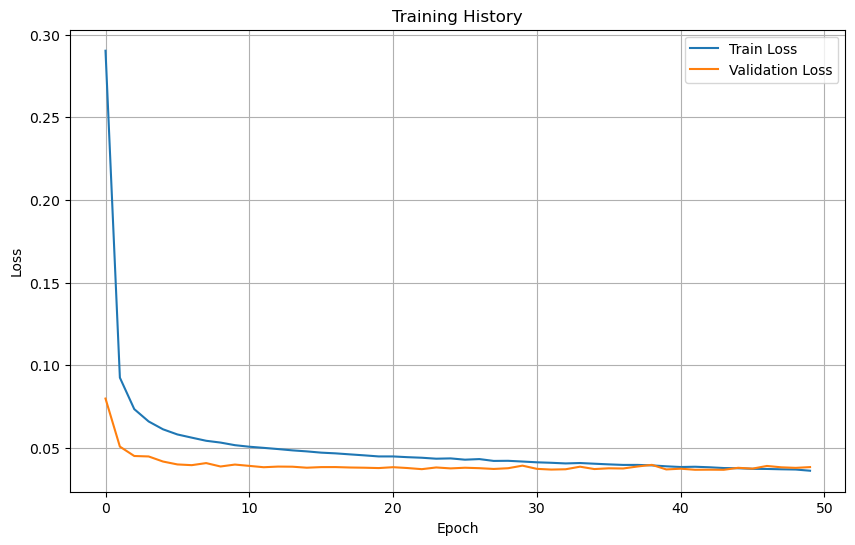

In [89]:
# 繪製損失曲線
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

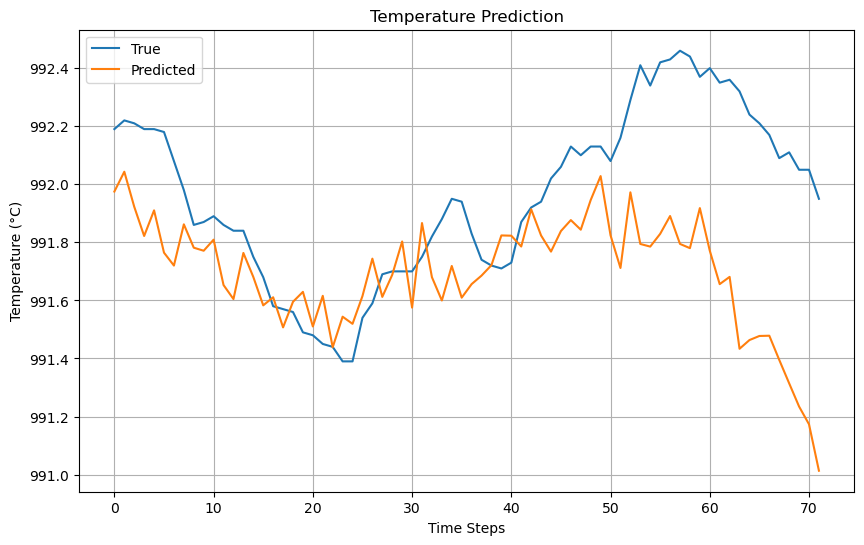

In [90]:
# 預測和可視化
def plot_prediction(model, x, y_true, scaler, device):
    model.eval()
    with torch.no_grad():
        x = torch.FloatTensor(x).unsqueeze(0).to(device)
        y_pred = model(x).cpu().numpy()[0]
        
    # 反標準化
    y_true = y_true * scaler.scale_[1] + scaler.mean_[1]
    y_pred = y_pred * scaler.scale_[1] + scaler.mean_[1]
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_true)), y_true, label='True')
    plt.plot(range(len(y_pred)), y_pred, label='Predicted')
    plt.legend()
    plt.title('Temperature Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Temperature (°C)')
    plt.grid(True)
    plt.show()

# 顯示一個隨機樣本的預測結果
idx = np.random.randint(len(X_valid))
plot_prediction(model, X_valid[idx], y_valid[idx], scaler, device)

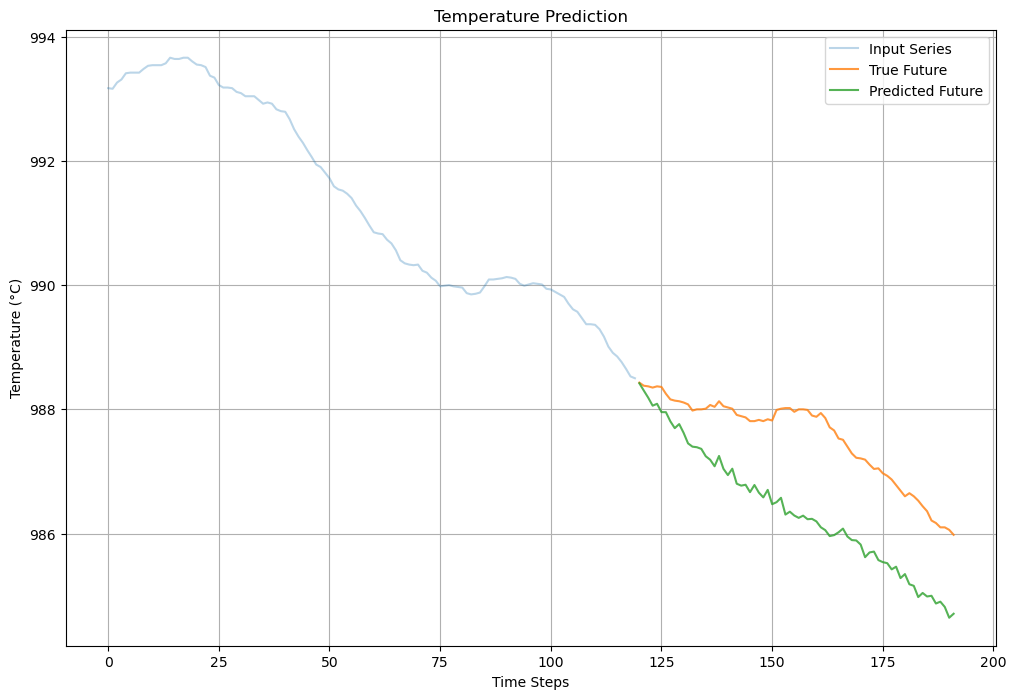

MAE: 1.1615


In [92]:
def plot_series(x_data, y, y_pred):
    plt.figure(figsize=(12, 8))
    # 繪製輸入序列
    plt.plot(range(len(x_data)), x_data, label='Input Series', alpha=0.3)
    
    # 繪製真實值和預測值
    input_len = len(x_data)
    plt.plot(range(input_len, input_len + len(y)), y, 
             label='True Future', alpha=0.8)
    plt.plot(range(input_len, input_len + len(y_pred)), y_pred, 
             label='Predicted Future', alpha=0.8)
    
    plt.legend()
    plt.title('Temperature Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Temperature (°C)')
    plt.grid(True)
    plt.show()

# 計算並顯示預測結果
def show_prediction_with_mae():
    # 獲取一個驗證集樣本
    x, y_true = next(iter(valid_loader))
    x, y_true = x.to(device), y_true.to(device)
    
    # 進行預測
    model.eval()
    with torch.no_grad():
        y_pred = model(x)
    
    # 選擇第一個樣本
    x = x[0].cpu().numpy()
    y_true = y_true[0].cpu().numpy()
    y_pred = y_pred[0].cpu().numpy()
    
    # 反標準化
    x_temp = x[:, 1] * scaler.scale_[1] + scaler.mean_[1]
    y_true = y_true * scaler.scale_[1] + scaler.mean_[1]
    y_pred = y_pred * scaler.scale_[1] + scaler.mean_[1]
    
    # 繪製圖表
    plot_series(x_temp, y_true, y_pred)
    
    # 計算MAE
    mae = np.mean(np.abs(y_pred - y_true))
    print(f'MAE: {mae:.4f}')

# 執行預測和可視化
show_prediction_with_mae()